In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from synthpop.abstract import AbstractMetaGenerator, AbstractGenerator
from synthpop.models.solar_system import SolarSystem
from synthpop.infer.smcabc import RejectionSampling, IntervalKernel
from sbi.inference import prepare_for_sbi, simulate_for_sbi
from sbi.analysis import pairplot
import sbi

In [7]:
def loss(x):
    """
    Check that planets have circular orbits.
    """
    x = x[0]
    ret = 0.0
    n_agents = x.shape[1]
    for i in range(n_agents):
        error = torch.std(torch.sqrt(x[:,i, 0]**2 + x[:,i, 1]**2))
        ret += error
    return ret / n_agents

class Generator(AbstractGenerator):
    def __init__(self, params):
        self.dist = torch.distributions.MultivariateNormal(params, 0.1 * torch.eye(4))

    def __call__(self, n_agents):
        return self.dist.sample((n_agents,))

class MetaGenerator(AbstractMetaGenerator):
    def __init__(self):
        pass

    def __call__(self, params):
        return Generator(params)

In [83]:
ss = SolarSystem(n_agents=1, t_final=400, n_timesteps=200)

In [84]:
def simulate(theta):
    generator = Generator(theta)
    x = ss(generator)
    l = loss(x)
    return l.reshape(1)

prior = sbi.utils.BoxUniform(low=torch.tensor([-3, 1, 1, -3]), high=torch.tensor([1, 3, 3, 1]))

def distance(y, x):
    return x.reshape(-1)

In [85]:
simulator, prior = prepare_for_sbi(simulate, prior)

In [86]:
smcabc_sampler = sbi.inference.SMCABC(simulator, prior, num_workers=-1, distance=distance)
smcabc_sampler.distance = distance

In [87]:
shifted_samples = smcabc_sampler(0., 1_000, 5_000, int(1e4), 1.)

Running 287 simulations in 287 batches.: 100%|██████████| 287/287 [00:01<00:00, 263.51it/s]


(<Figure size 1000x1000 with 16 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='dim 4'>]],
       dtype=object))

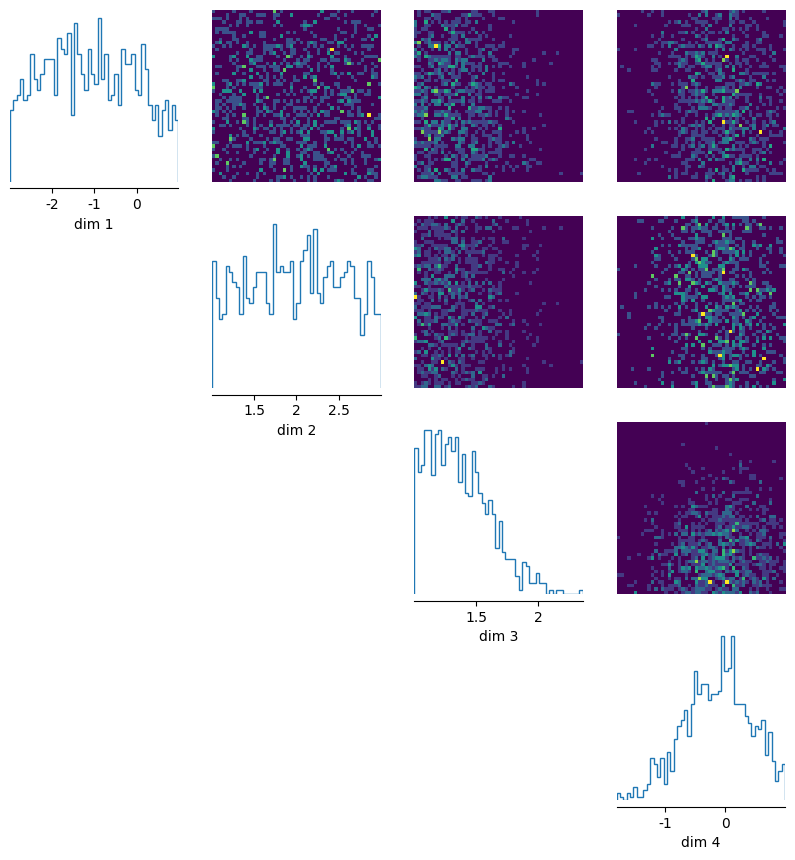

In [89]:
pairplot(shifted_samples)

In [94]:
generator = Generator(shifted_samples[0,:])
x = ss(generator)

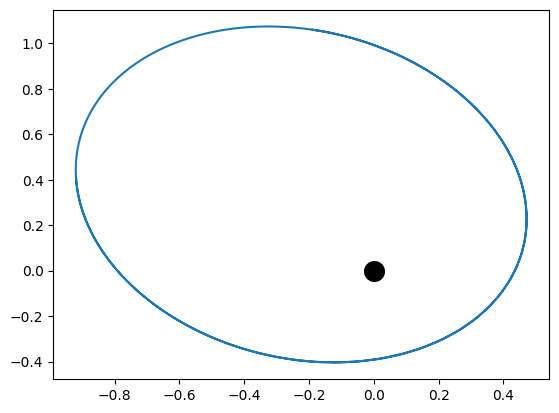

In [96]:
f, ax = plt.subplots()
for i in range(1):
    ax.plot(x[0][:,i:,0], x[0][:,i,1])
ax.scatter(0, 0, color = "black", s=200)
